<a href="https://colab.research.google.com/github/PraeJi/SecondHandCarPrice_Regression/blob/main/SecondHandCarPrice_Prediction_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Import libraries
- Prepare data: Categorical and numerical features
- Train linear regression model
- Train one-layer neural network model for regression (equivalent to linear regression)
- Train multi-layer neural network model for regression

In [1]:
import os
import os.path as op

import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import joblib

# Data Preparation

- Download data from https://github.com/biodatlab/deep-learning-skooldio
- Clean and split data

In [2]:
!git clone https://github.com/biodatlab/deep-learning-skooldio

Cloning into 'deep-learning-skooldio'...
remote: Enumerating objects: 2064, done.
remote: Counting objects: 100% (358/358), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 2064 (delta 194), reused 253 (delta 129), pack-reused 1706 (from 1)
Receiving objects: 100% (2064/2064), 17.11 MiB | 9.35 MiB/s, done.
Resolving deltas: 100% (205/205), done.
Updating files: 100% (1795/1795), done.


In [3]:
df = pd.read_csv(op.join('deep-learning-skooldio','rodkaidee-dataset','Rodkaidee Data.csv'))
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022,"15,640",กรุงเทพมหานคร,"499,000",Gray
1,Suzuki,Celerio,1.0,Eco Car,2021,"9,545",กรุงเทพมหานคร,"315,000",White
2,Mitsubishi,Mirage,1.2,Eco Car,2021,"10,900",นนทบุรี,"335,000",Gray
3,Nissan,March,1.2,Eco Car,2021,"12,000",กรุงเทพมหานคร,"339,000",Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021,"25,706",กาญจนบุรี,"350,000",Gray


In [4]:
df.shape

(7396, 9)

# Clean and Split data

In [5]:
import os.path as op

# Clean price and mileage from string to float
df['Mileage'] = df['Mileage'].apply(lambda x: float(x.replace(',','')))
df['Price'] = df['Price'].apply(lambda x: float(x.replace(',','')))

# Split dataset using `train_test_split` to 80% train and 20% test
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
df_train.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
6370,Toyota,Vios,1.5,B-Segment,2008,150000.0,สงขลา,259000.0,Gray
3915,Toyota,Altis,1.8,C-Segment,2013,101266.0,กรุงเทพมหานคร,299000.0,Black
7194,Honda,Civic,1.7,C-Segment,2003,280000.0,สระบุรี,119000.0,Gold
2318,Mazda,Mazda3,2.0,C-Segment,2016,74111.0,กรุงเทพมหานคร,430000.0,Silver
6677,Toyota,Camry,2.0,D-Segment,2007,263489.0,กรุงเทพมหานคร,288000.0,Brown


In [7]:
# Check image size
len(df_train), len(df_val)

(5916, 1480)

# Apply One-hot Encoding to categorical values

In [8]:
# Create one-hot encoder class using OneHotEncoder for transforming categorical columns in variable name ``ohe``
CAT_COLUMN = ["Brand","Model","Engine","Segment","Province","Color"] # list feature ที่เป็น category

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # แปลง dataframe ให้เป็น array //สร้าง instance ของ class OneHotEncoder
cat_brand = ohe.fit_transform(df_train[['Brand']]) # แปลง column dataframe ที่เราต้องการ ให้เป็น one hot encoder // ทดลองทำ one hot encoder แค่ feature เดียว

In [9]:
df.Brand.unique() # check value ของ Brand (ใช้ยูนีค)

array(['Mazda', 'Suzuki', 'Mitsubishi', 'Nissan', 'Toyota', 'Honda'],
      dtype=object)

In [10]:
len(df.Brand.unique()) # check จำนวนของ Brand

6

In [11]:
cat_brand

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [12]:
cat_brand.shape

(5916, 6)

In [13]:
cat_val_brand = ohe.transform(df_val[['Brand']])

In [14]:
cat_val_brand

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]])

In [15]:
# Use ``ohe`` to transform our dataframe

cat_train_array = ohe.fit_transform(df_train[CAT_COLUMN]) # ทำ one hot encoder ทีเดียวทุก feature

In [16]:
cat_val_array = ohe.transform(df_val[CAT_COLUMN])

In [17]:
cat_train_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [18]:
cat_train_array.shape, cat_val_array.shape

((5916, 136), (1480, 136))

# Normalize continuous values

We will use MinMaxScaler to normalize continuous value. For example, column X has values from 0 to 1000000, so we need to normalize them to 0 to 1. Alternatively StandardScaler is also an option.

In [19]:
# Create MinMaxScaler for numerical (continuous) columns

year_scaler = MinMaxScaler()
mileage_scaler = MinMaxScaler()
price_scaler = MinMaxScaler()

In [20]:
# Use Scaler to transform our dataframe

scaled_year = year_scaler.fit_transform(df_train[['Year']])
scaled_mileage = mileage_scaler.fit_transform(df_train[['Mileage']])
scaled_price = price_scaler.fit_transform(df_train[['Price']])

In [21]:
scaled_year

array([[0.38095238],
       [0.61904762],
       [0.14285714],
       ...,
       [0.52380952],
       [0.85714286],
       [0.0952381 ]])

In [22]:
scaled_mileage

array([[0.25213312],
       [0.16930006],
       [0.47309379],
       ...,
       [0.16714825],
       [0.08216337],
       [0.35411497]])

# Apply one-hot encoding and normalization to create train and test dataset

In [23]:
# Apply one-hot encoder and MinMaxScaler to the training and validation dataframe

x_train = np.hstack([
    ohe.transform(df_train[CAT_COLUMN]),
    year_scaler.transform(df_train[['Year']]),
    mileage_scaler.transform(df_train[['Mileage']])
])

y_train = price_scaler.transform(df_train[['Price']])

x_val = np.hstack([
    ohe.transform(df_val[CAT_COLUMN]),
    year_scaler.transform(df_val[['Year']]),
    mileage_scaler.transform(df_val[['Mileage']])
])

y_val = price_scaler.transform(df_val[['Price']])

In [24]:
x_train.shape, y_train.shape

((5916, 138), (5916, 1))

In [25]:
x_val.shape, y_val.shape

((1480, 138), (1480, 1))

In [26]:
# save one-hot encoder and scaler objects with joblib
save_dir = 'trained_models'
os.makedirs(save_dir, exist_ok=True)
joblib.dump(ohe, op.join(save_dir, "one_hot_encoder.joblib"))
joblib.dump(year_scaler, op.join(save_dir, "year_scaler.joblib"))
joblib.dump(mileage_scaler, op.join(save_dir, "mileage_scaler.joblib"))
joblib.dump(price_scaler, op.join(save_dir, "price_scaler.joblib"))

['trained_models/price_scaler.joblib']

# Train a Linear Regression Model

In [27]:
# create a linear regression model and fit to the training data.

lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [28]:
y_pred = lr_model.predict(x_val)
y_pred.shape

(1480, 1)

In [29]:
y_pred

array([[0.25053805],
       [0.27983299],
       [0.17263115],
       ...,
       [0.35946615],
       [0.33207586],
       [0.20616316]])

In [30]:
y_val

array([[0.21989906],
       [0.25378515],
       [0.1888969 ],
       ...,
       [0.35039654],
       [0.32011536],
       [0.16372026]])

In [31]:
price_scaler.inverse_transform(y_pred)

array([[380496.27347563],
       [421128.35865657],
       [272439.40537757],
       ...,
       [531579.54830609],
       [493589.22110596],
       [318948.29859058]])

In [32]:
price_scaler.inverse_transform(y_val)

array([[338000.],
       [385000.],
       [295000.],
       ...,
       [519000.],
       [477000.],
       [260080.]])

In [33]:
# เพิ่ม column ผลลัพธ์ predicted ใน df_val
df_val['Predicted_Price_LR'] = price_scaler.inverse_transform(y_pred).ravel()

In [34]:
df_val

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Predicted_Price_LR
2759,Toyota,Vios,1.5,B-Segment,2015,62639.0,กรุงเทพมหานคร,338000.0,Gray,380496.273476
2846,Toyota,Altis,1.6,C-Segment,2015,65615.0,สงขลา,385000.0,Silver,421128.358657
6682,Honda,Civic,2.0,C-Segment,2007,203000.0,สิงห์บุรี,295000.0,Gray,272439.405378
3262,Toyota,Yaris,1.2,Eco Car,2014,124007.0,ราชบุรี,339000.0,White,298120.244429
486,Mazda,Mazda2,1.3,B-Segment,2019,51957.0,กรุงเทพมหานคร,439000.0,Blue,458681.852892
...,...,...,...,...,...,...,...,...,...,...
6782,Toyota,Yaris,1.5,Eco Car,2006,156479.0,กรุงเทพมหานคร,185000.0,Gray,109925.948658
110,Mitsubishi,Attrage,1.2,Eco Car,2020,13000.0,สระบุรี,385000.0,White,413265.338868
51,Toyota,Yaris,1.2,Eco Car,2021,2000.0,นนทบุรี,519000.0,White,531579.548306
1109,Toyota,Altis,1.6,C-Segment,2018,94970.0,นนทบุรี,477000.0,Gray,493589.221106


# Evaluate and plot relationship between actual and predicted values

In [35]:
# Calculate the mean squared error between actual value and prediction

# TODO: Create your own MSE
print("MSE = ",((y_val-y_pred)**2).sum() / len(y_val))

# TODO: Use `mean_squared_error` from scikit learn
print("MSE (scikit learn) = ",mean_squared_error(y_val, y_pred))

"""
mse ต่ำ แปลว่า error น้อย = ดี
"""

MSE =  0.003113008331777465
MSE (scikit learn) =  0.003113008331777465


'\nmse ต่ำ แปลว่า error น้อย = ดี\n'

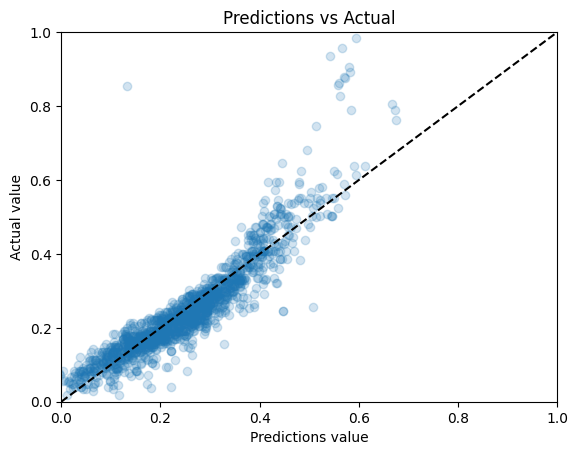

In [36]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.Figure(figsize=(10, 10))
plt.scatter(y_pred, y_val, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [37]:
joblib.dump(lr_model, "trained_models/carprice_model_linear_regression.joblib")

['trained_models/carprice_model_linear_regression.joblib']

# Train a Neural Network to predict car price

In [38]:
from torch.utils.data import Dataset, DataLoader

# Create dataset from numpy array X,y

class CarPriceDataset(Dataset):
  def __init__(self, X, y = None):
    self.X = X
    if y is not None: # ถ้า Y ไม่ใช่ค่า None
      self.y = y
    else:
      self.y = None

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    if self.y is not None:
      return self.X[idx], self.y[idx]
    else:
      return self.X[idx]

In [39]:
# Create dataset and dataloader

train_dataset = CarPriceDataset(x_train, y_train)
val_dataset = CarPriceDataset(x_val, y_val)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

x_sample, y_sample = next(iter(train_dataloader))
x_sample.shape, y_sample.shape

(torch.Size([32, 138]), torch.Size([32, 1]))

In [40]:
class CarPriceModel(nn.Module):
  def __init__(self, input_size, output_size):
    super().__init__()
    # Create a linear layer with input_size and output size
    self.linear = nn.Linear(input_size, output_size)

  def forward(self, x):
    # Create a forward pass
    x = self.linear(x)
    return x

In [41]:
# Create Model

n_feature, n_output = x_train.shape[1], y_train.shape[1]
print(n_feature, ",",n_output)
model = CarPriceModel(input_size=n_feature, output_size=n_output)
model

138 , 1


CarPriceModel(
  (linear): Linear(in_features=138, out_features=1, bias=True)
)

In [42]:
# Create Train Script

def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn = nn.MSELoss(reduction='mean'),
    num_epochs = 100,
    update_frequency = 10,
):
  for epoch in range(num_epochs):
    # Set the model to training mode.
    model.train()
    for x, y in train_dataloader:
      # Forward pass
      y_pred = model(x.float())

      # Calculate loss
      loss = loss_fn(y_pred, y.float())

      # Backward pass
      loss.backward()

      # Update the model parameters
      optimizer.step()

      # Reset the gradients
      optimizer.zero_grad()

    # Set the model to evaluation mode and calculate the test loss at the end of each epoch.
    model.eval()
    with torch.no_grad():
      for x, y in test_dataloader:
        # Forward pass
        y_pred = model(x.float())
        # Calculate the loss.
        loss = loss_fn(y_pred, y.float())

      # Print the loss if the epoch is a multiple of 10
      if epoch % update_frequency == 0:
        print(f"Epoch {epoch}: {loss.item()}")

In [43]:
# Define the loss function and the optimizer
learning_rate = 1e-3
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
num_epochs = 120
update_frequency = 10

train(
  model = model,
  train_dataloader = train_dataloader,
  test_dataloader = val_dataloader,
  optimizer = optimizer,
  loss_fn = loss_fn,
  num_epochs = num_epochs,
  update_frequency = update_frequency,
)

Epoch 0: 0.013553687371313572
Epoch 10: 0.0005853541661053896
Epoch 20: 0.0006950332317501307
Epoch 30: 0.0006944846827536821
Epoch 40: 0.0009524113265797496
Epoch 50: 0.0007198700332082808
Epoch 60: 0.0007385591161437333
Epoch 70: 0.0009002360748127103
Epoch 80: 0.0008860446978360415
Epoch 90: 0.0009060639422386885
Epoch 100: 0.0009154097642749548
Epoch 110: 0.0010587883880361915


# Evaluation the model on the test set with Mean Squared Error

In [44]:
def predict(model, dataloader):
  model.eval()
  y_pred_list = []
  y_true_list = []
  for x, y in dataloader:
    y_pred = model(x.float())
    prediction = y_pred.detach().numpy()
    y = y.numpy()
    y_pred_list.append(prediction)
    y_true_list.append(y)
  y_pred_list = np.concatenate(y_pred_list)
  y_true_list = np.concatenate(y_true_list)
  return y_pred_list, y_true_list

In [45]:
# get the predictions for the test set
y_pred, y_true = predict(model, val_dataloader)

In [46]:
mean_squared_error(y_true, y_pred)

0.0031208407869907175

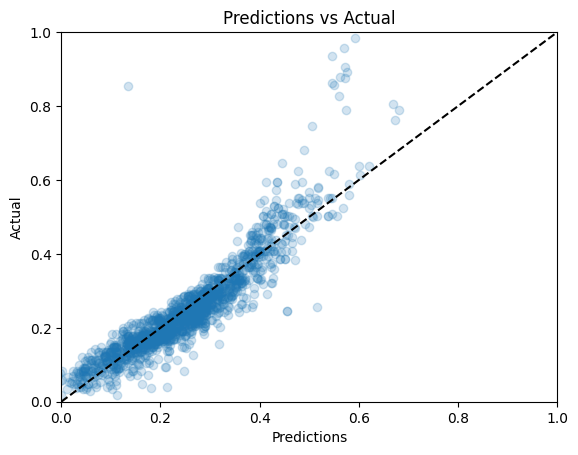

In [47]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_pred, y_true, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [48]:
torch.save(model.state_dict(), "trained_models/carprice_model_mse_0003.pth")

# Train a Neural network with multiple layers (MLP)

In [49]:
class CarPriceTwoLayerModel(nn.Module):
  def __init__(self, input_size, output_size, intermediate_dim = 10):
    super().__init__()
    # Create two layers neural network
    self.linear1 = nn.Linear(input_size, intermediate_dim)
    self.linear2 = nn.Linear(intermediate_dim, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.linear1(x)
    x = self.relu(x)
    x = self.linear2(x)
    return x

model_two_layers = CarPriceTwoLayerModel(input_size=n_feature, output_size=n_output)
model_two_layers

CarPriceTwoLayerModel(
  (linear1): Linear(in_features=138, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [50]:
# Define the loss function and the optimizer
learning_rate = 1e-3
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model_two_layers.parameters(), lr=learning_rate)

# Train the model
num_epochs = 120
update_frequency = 10

train(
  model = model_two_layers,
  train_dataloader = train_dataloader,
  test_dataloader = val_dataloader,
  optimizer = optimizer,
  loss_fn = loss_fn,
  num_epochs = num_epochs,
  update_frequency = update_frequency,
)

Epoch 0: 0.005994933191686869
Epoch 10: 0.0004354179254733026
Epoch 20: 0.0010436505544930696
Epoch 30: 0.0010701732244342566
Epoch 40: 0.0011177692795172334
Epoch 50: 0.0011161325965076685
Epoch 60: 0.0009875585092231631
Epoch 70: 0.0008580007124692202
Epoch 80: 0.0006343204877339303
Epoch 90: 0.000964334758464247
Epoch 100: 0.0009667329723015428
Epoch 110: 0.0004823351337108761


In [51]:
y_test, y_true_dl = predict(model_two_layers, val_dataloader)
mse_score = mean_squared_error(y_test, y_true_dl)
mse_score

0.0018793983808459724

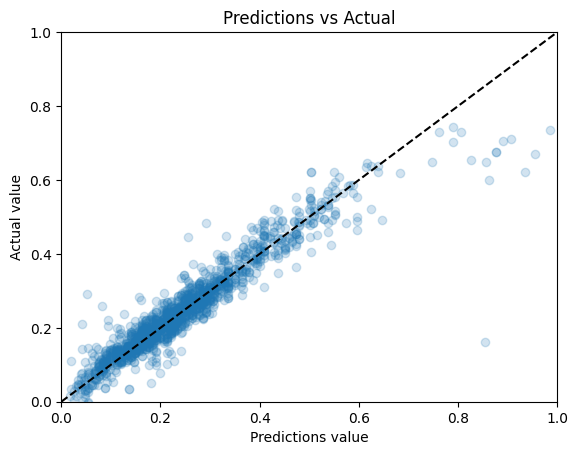

In [52]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(y_true_dl, y_test, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.title("Predictions vs Actual")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [53]:
torch.save(model_two_layers.state_dict(), f"trained_models/carprice_two_layer_model_mse_00015.pth")

# Use the models to predict on new data

- Create a model
- Load one-hot-encoder and scaler
- Transform dataframe
- Predict

In [54]:
import joblib
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [55]:
# load data (similar to previous code)

df = pd.read_csv(op.join("deep-learning-skooldio", "rodkaidee-dataset", "Rodkaidee Data.csv"))
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

_, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [56]:
# TODO: create model and load trained weights
class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        # TODO: Create layers
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # TODO: Forward pass
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

model = CarPriceTwoLayerModel(138, 1)
# TODO: load trained weights
model.load_state_dict(torch.load("trained_models/carprice_two_layer_model_mse_00015.pth"))

<ipython-input-56-7741967ac77c>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_models/carprice_two_layer_model_mse_00015.pth"))


<All keys matched successfully>

In [57]:
# TODO: Load one-hot encoder
one_hot_encoder_path = "trained_models/one_hot_encoder.joblib"
year_scaler_path = "trained_models/year_scaler.joblib"
mileage_scaler_path = "trained_models/mileage_scaler.joblib"
price_scaler_path = "trained_models/price_scaler.joblib"

ohe = joblib.load(one_hot_encoder_path)
year_scaler = joblib.load(year_scaler_path)
mileage_scaler = joblib.load(mileage_scaler_path)
price_scaler = joblib.load(price_scaler_path)

In [58]:
class CarPriceDataset(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [59]:
# prepare test dataset
CAT_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
X_test = np.hstack([
    ohe.transform(df_test[CAT_COLUMNS]),
    year_scaler.transform(df_test[["Year"]]),
    mileage_scaler.transform(df_test[["Mileage"]]),
])
test_dataset = CarPriceDataset(X_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [60]:
def predict(model, test_dataloader):
    model.eval()
    y_pred_list = []
    for x in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y_pred_list.extend(prediction)
    y_pred_list = np.concatenate(y_pred_list)
    return y_pred_list

In [61]:
y_pred = predict(model, test_dataloader)
y_pred_price = price_scaler.inverse_transform(y_pred.reshape(-1, 1))

In [62]:
y_pred

array([0.23021655, 0.29181743, 0.19339408, ..., 0.35958332, 0.33203876,
       0.18162523], dtype=float32)

In [63]:
y_pred_price

array([[352310.38],
       [437750.78],
       [301237.6 ],
       ...,
       [531742.06],
       [493537.75],
       [284914.2 ]], dtype=float32)

In [64]:
df_test["Pred_Price"] = y_pred_price

In [65]:
df_test.head()

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Pred_Price
2759,Toyota,Vios,1.5,B-Segment,2015,62639.0,กรุงเทพมหานคร,338000.0,Gray,352310.37500
2846,Toyota,Altis,1.6,C-Segment,2015,65615.0,สงขลา,385000.0,Silver,437750.78125
6682,Honda,Civic,2.0,C-Segment,2007,203000.0,สิงห์บุรี,295000.0,Gray,301237.59375
3262,Toyota,Yaris,1.2,Eco Car,2014,124007.0,ราชบุรี,339000.0,White,336619.31250
486,Mazda,Mazda2,1.3,B-Segment,2019,51957.0,กรุงเทพมหานคร,439000.0,Blue,428296.53125


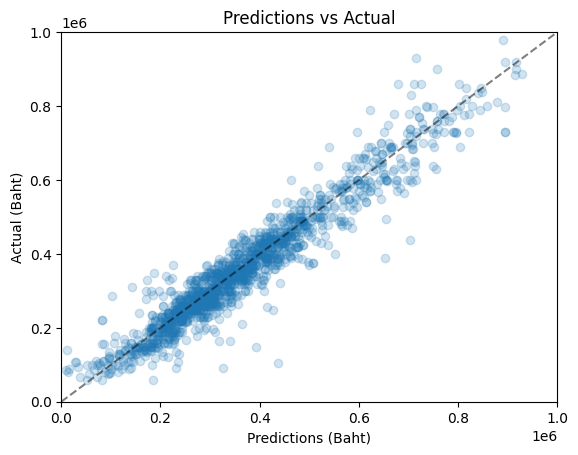

In [66]:
plt.plot([0, 1_000_000], [0, 1_000_000], color="black", alpha=0.5, linestyle="--")

plt.scatter(df_test["Pred_Price"].values, df_test["Price"], alpha=0.2)
plt.xlabel("Predictions (Baht)")
plt.ylabel("Actual (Baht)")
plt.title("Predictions vs Actual")

plt.xlim(0, 1_000_000)
plt.ylim(0, 1_000_000)
plt.show()

# Apply with Gradio

In [ ]:
!pip install gradio==3.35.0
!pip install

In [ ]:
import joblib
import numpy as np
import pandas as pd
import gradio as gr

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class CarPriceDataset(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

class CarPriceTwoLayerModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Load model
pred_model = CarPriceTwoLayerModel(138, 1)
pred_model.load_state_dict(torch.load("trained_models/carprice_two_layer_model_mse_00015.pth"))

# Load one-hot encoder and scaler
ohe = joblib.load("trained_models/one_hot_encoder.joblib")
year_scaler = joblib.load("trained_models/year_scaler.joblib")
mileage_scaler = joblib.load("trained_models/mileage_scaler.joblib")
price_scaler = joblib.load("trained_models/price_scaler.joblib")

In [ ]:
CAT_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]

def predict(model, data_loader):
    model.eval()
    y_pred_list = []
    for x in data_loader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y_pred_list.extend(prediction)
    y_pred_list = np.concatenate(y_pred_list)
    return y_pred_list


def predict_car_price(
    brand: str, model: str, engine: float, segment: str, province: str,
    color: str, year: float, mileage: float
):
    df = pd.DataFrame([{
      "Brand": brand,
      "Model": model,
      "Engine": engine,
      "Segment": segment,
      "Province": province,
      "Color": color,
      "Year": year,
      "Mileage": mileage,
    }])
    features = np.hstack([
        ohe.transform(df[CAT_COLUMNS]),
        year_scaler.transform(df[["Year"]]),
        mileage_scaler.transform(df[["Mileage"]])
    ])
    feat_dataset = CarPriceDataset(features)
    dataloaders = DataLoader(feat_dataset, batch_size=32, shuffle=False)
    y_pred_lr = predict(pred_model, dataloaders)
    return int(price_scaler.inverse_transform(y_pred_lr.reshape(-1, 1)).ravel()[0])

In [ ]:
brands = [
  'Toyota', 'Honda', 'Mazda', 'Mitsubishi',
  'Nissan', 'Suzuki'
]
models = [
  'Vios', 'Altis', 'Civic', 'Mazda3', 'Camry',
  'Mirage', 'Brio', 'Lancer Ex', 'Jazz', 'Accord',
  'Lancer', 'Yaris', 'Almera', 'City', 'Swift', 'Mazda2',
  'Teana', 'Note', 'Celerio', 'March', 'Tiida', 'Prius',
  'Ciaz', 'Sylphy', 'Pulsar', 'Attrage', 'Sunny'
]
engines = [
  1.5, 1.8, 1.7, 2.0, 1.2, 1.6, 2.4,
  2.5, 1.0, 1.3, 2.3, 3.0, 2.2
]
segments = ['B-Segment', 'C-Segment', 'D-Segment', 'Eco Car']
provinces = [
  'สงขลา', 'กรุงเทพมหานคร', 'สระบุรี', 'ชัยนาท', 'ระยอง', 'นครสวรรค์',
  'นนทบุรี', 'ตาก', 'สมุทรสาคร', 'เชียงใหม่', 'ลำปาง', 'สุพรรณบุรี', 'เชียงราย',
  'เพชรบุรี', 'พิษณุโลก', 'นครปฐม', 'อุดรธานี', 'สมุทรปราการ', 'ปทุมธานี',
  'นครราชสีมา', 'ชลบุรี', 'ปัตตานี', 'ราชบุรี', 'ลำพูน', 'กระบี่', 'ฉะเชิงเทรา',
  'พัทลุง', 'อ่างทอง', 'ขอนแก่น', 'ปราจีนบุรี', 'สุราษฎร์ธานี', 'ภูเก็ต',
  'หนองบัวลำภู', 'พิจิตร', 'พะเยา', 'ตราด', 'นครศรีธรรมราช', 'บุรีรัมย์',
  'ลพบุรี', 'อุตรดิตถ์', 'ยโสธร', 'อุบลราชธานี', 'สิงห์บุรี', 'พระนครศรีอยุธยา',
  'กาฬสินธุ์', 'สกลนคร', 'ร้อยเอ็ด', 'ระนอง', 'นครพนม', 'อุทัยธานี', 'จันทบุรี',
  'มหาสารคาม', 'กาญจนบุรี', 'แพร่', 'บึงกาฬ', 'กำแพงเพชร', 'สมุทรสงคราม',
  'สุโขทัย', 'ตรัง', 'แม่ฮ่องสอน', 'อำนาจเจริญ', 'นครนายก', 'ชัยภูมิ', 'พังงา',
  'สระแก้ว', 'สุรินทร์', 'นราธิวาส', 'สตูล', 'ประจวบคีรีขันธ์', 'เพชรบูรณ์', 'ศรีสะเกษ',
  'หนองคาย', 'ยะลา', 'น่าน'
]
colors = ['Gray', 'Black', 'Gold', 'Silver', 'Brown', 'White',
          'Red', 'Yellow', 'Blue', 'Green', 'Cyan', 'Orange']

In [ ]:
# ตัวอย่างของข้อมูล
examples = [
  ['Honda', 'Civic', 1.8, 'C-Segment', 'ตรัง', 'Gray', 2009, 185477.0],
  ['Honda', 'Accord', 2.4, 'D-Segment', 'ขอนแก่น', 'Black', 2003, 166508.0],
  ['Honda', 'Jazz', 1.5, 'B-Segment', 'กรุงเทพมหานคร', 'White', 2011, 62000.0],
  ['Honda', 'Civic', 1.8, 'C-Segment', 'พระนครศรีอยุธยา', 'White', 2012, 165346.0],
  ['Suzuki', 'Swift', 1.2, 'Eco Car', 'กรุงเทพมหานคร', 'White', 2016, 193000.0],
  ['Honda', 'City', 1.0, 'B-Segment', 'กรุงเทพมหานคร', 'Gray', 2020, 29000.0],
  ['Honda', 'City', 1.5, 'B-Segment', 'พิษณุโลก', 'Gray', 2007, 126208.0],
  ['Toyota', 'Yaris', 1.5, 'Eco Car', 'เชียงใหม่', 'White', 2013, 100000.0],
  ['Toyota', 'Altis', 1.6, 'C-Segment', 'กรุงเทพมหานคร', 'Silver', 2009, 260000.0],
  ['Honda', 'Civic', 1.8, 'C-Segment', 'กรุงเทพมหานคร', 'Silver', 2006, 232433.0],
]

interface = gr.Interface(
    fn=predict_car_price,
    inputs=[
      gr.Dropdown(brands, label="Brand", info="Select Car Brand"),
      gr.Dropdown(models, label="Model", info="Select Car Model"),
      gr.Dropdown(engines, label="Engine Size", info="Select Engine Size"),
      gr.Dropdown(segments, label="Car segment", info="Select Car Segment"),
      gr.Dropdown(provinces, label="Province", info="Select Province"),
      gr.Dropdown(colors, label="Color", info="Select Color"),
      gr.Slider(1990, 2023, label="Year", info="Select Year"),
      gr.Slider(0, 400000, label="Mileage", info="Select Mileage"),
    ],
    outputs=gr.Textbox(label="ราคาทำนาย (บาท)", placeholder="xxx,xxx (บาท)"),
    examples=examples,
    title="ทำนายราคารถมือสอง",
    description="ตัวอย่างแอพพลิเคชั่นสำหรับคำนวณราคารถมือสอง",
)
interface.launch()